## DC House Price

#### Project goal: 

- Predict the median house price in DC
- use the right housing statistics and macro variables: (1) time series, (2) acf/pacf plots, (3) stationary test and (4) autocorrelation test
- Modeling: time series linear regression: feature selection in R-squared, AIC, etc.
- Cross validation: Out-of-time performance
- Residual analysis: (1) normality test, (2) Q-Q plot, (3) MAE, (4) MAPE, (5) Homoscedastic test, (6) stationary test and (7) autocorrelation test 

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.compat import lzip

%matplotlib inline

In [2]:
# feature selection: KBest using f_regression, chi2, mutual_info_regression
from sklearn.feature_selection import SelectKBest, f_classif, f_regression, chi2, mutual_info_regression

# tests for stationary 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

import statsmodels.api as sm

#tests for autocorrelation
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox

#test of Heteroscedasticity
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_goldfeldquandt

#test for cointegration
from statsmodels.tsa.vector_ar.vecm import coint_johansen 

In [14]:
df = pd.read_csv("../data/full_data.csv")

In [15]:
df.tail()

,Time,Median Sale Price,Median Sale Price MoM,Homes Sold,Homes Sold MoM,New Listings,New Listings MoM,Inventory,Inventory MoM,Days on Market,...,WDXRSA,US_UR,DMV_UR,DC_UR,FED_EM,FIN_EM,HOS_EM,DC_PER,DMV_PER,DMV_PER_1
112,2019-Jun,325000.0,2.5,1089.0,-9.3,1162.0,-20.2,1752.0,0.2,20,...,232.112524,3.7,3.4,5.6,363.193444,103.253989,347.332822,389.0,2036.740005,1178.709018
113,2019-Jul,318000.0,-2.2,1094.0,0.5,1172.0,0.9,1694.0,-3.3,22,...,232.032415,3.7,3.3,5.6,363.391729,102.106994,347.357406,455.0,2056.199932,1138.927749
114,2019-Aug,300000.0,-5.7,1074.0,-1.8,972.0,-17.1,1540.0,-9.1,25,...,232.650097,3.7,3.2,5.5,364.342848,102.964051,350.489560,437.0,2000.434352,1247.029523
115,2019-Sep,315000.0,5.0,888.0,-17.3,1218.0,25.3,1692.0,9.9,25,...,233.380305,3.5,2.9,5.4,363.321499,102.012584,352.846320,329.0,2083.453745,1429.372493
116,2019-Oct,330000.0,4.7,982.0,10.6,1100.0,-9.7,1735.0,2.5,25,...,234.644022,3.6,2.8,5.4,363.261555,103.049750,355.226651,1395.0,2651.639321,1163.982510


In [16]:
df_test = df.drop(columns=['Time', 'DATE', 'Median Sale Price MoM', 'New Listings MoM', 'Homes Sold MoM', 'Inventory MoM', 'Days on Market MoM', 'Average Sale To List MoM', 'DC_PER'])
col_name = df_test.columns

In [17]:
# create a log transformed variable
for i in range(len(col_name)):
    df[col_name[i] + '_log'] =  np.log(df[col_name[i]])

In [18]:
df_test = df.drop(columns=['Time', 'DATE'])
col_name = df_test.columns
col_name

Index(['Median Sale Price', 'Median Sale Price MoM', 'Homes Sold',
       'Homes Sold MoM', 'New Listings', 'New Listings MoM', 'Inventory',
       'Inventory MoM', 'Days on Market', 'Days on Market MoM',
       'Average Sale To List%', 'Average Sale To List MoM', 'WDXRSA', 'US_UR',
       'DMV_UR', 'DC_UR', 'FED_EM', 'FIN_EM', 'HOS_EM', 'DC_PER', 'DMV_PER',
       'DMV_PER_1', 'Median Sale Price_log', 'Homes Sold_log',
       'New Listings_log', 'Inventory_log', 'Days on Market_log',
       'Average Sale To List%_log', 'WDXRSA_log', 'US_UR_log', 'DMV_UR_log',
       'DC_UR_log', 'FED_EM_log', 'FIN_EM_log', 'HOS_EM_log', 'DMV_PER_log',
       'DMV_PER_1_log'],
      dtype='object')

In [19]:
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

In [20]:
df1 = pd.DataFrame(df['Time'][1:117])
# create a log transformed variable
for i in range(len(col_name)):
    df1[col_name[i] + '_1diff'] = difference(df[col_name[i]])

In [21]:
df1

,Time,Median Sale Price_1diff,Median Sale Price MoM_1diff,Homes Sold_1diff,Homes Sold MoM_1diff,New Listings_1diff,New Listings MoM_1diff,Inventory_1diff,Inventory MoM_1diff,Days on Market_1diff,...,Average Sale To List%_log_1diff,WDXRSA_log_1diff,US_UR_log_1diff,DMV_UR_log_1diff,DC_UR_log_1diff,FED_EM_log_1diff,FIN_EM_log_1diff,HOS_EM_log_1diff,DMV_PER_log_1diff,DMV_PER_1_log_1diff
1,2010-Mar,-13000.0,-16.3,265.0,54.8,596.0,57.2,324.0,3.2,-9,...,0.000000,-0.003139,0.010152,-0.029414,-0.020834,0.001249,0.002790,0.016275,-0.192304,-0.115160
2,2010-Apr,23000.0,14.9,123.0,-35.3,38.0,-52.6,222.0,-3.7,-14,...,-0.001019,0.011589,0.000000,-0.093819,-0.010582,0.004076,-0.002135,0.014622,0.037911,0.079167
3,2010-May,-10000.0,-13.5,79.0,-6.9,-690.0,-42.4,-18.0,-6.5,2,...,-0.001020,0.005486,-0.030772,0.032261,-0.010695,0.023673,0.002529,-0.008461,-0.149028,-0.203737
4,2010-Jun,-10000.0,-0.2,-26.0,-11.3,231.0,62.5,33.0,1.4,5,...,0.000000,0.005211,-0.021053,0.031253,0.000000,-0.001574,0.002504,0.004022,0.088073,0.172807
5,2010-Jul,0.0,4.0,-286.0,-27.1,-150.0,-34.3,-36.0,-1.8,10,...,-0.002043,-0.001088,0.000000,-0.015504,-0.010811,-0.001504,0.001281,-0.000768,0.064944,0.008507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,2019-Jun,8000.0,2.1,-111.0,-15.2,-295.0,-27.1,3.0,-6.8,0,...,-0.002002,0.001236,0.027399,0.092373,-0.017700,0.000038,0.006848,0.005231,-0.123683,-0.114050
113,2019-Jul,-7000.0,-4.7,5.0,9.8,10.0,21.1,-58.0,-3.5,2,...,0.002002,-0.000345,0.000000,-0.029853,0.000000,0.000546,-0.011171,0.000071,0.009509,-0.034333
114,2019-Aug,-18000.0,-3.5,-20.0,-2.3,-200.0,-18.0,-154.0,-5.8,3,...,-0.003005,0.002659,0.000000,-0.030772,-0.018019,0.002614,0.008359,0.008977,-0.027495,0.090677
115,2019-Sep,15000.0,10.7,-186.0,-15.5,246.0,42.4,152.0,19.0,0,...,-0.003014,0.003134,-0.055570,-0.098440,-0.018349,-0.002807,-0.009284,0.006702,0.040663,0.136471


In [22]:
col_name1 = df1.drop(columns=['Time']).columns
col_name1

Index(['Median Sale Price_1diff', 'Median Sale Price MoM_1diff',
       'Homes Sold_1diff', 'Homes Sold MoM_1diff', 'New Listings_1diff',
       'New Listings MoM_1diff', 'Inventory_1diff', 'Inventory MoM_1diff',
       'Days on Market_1diff', 'Days on Market MoM_1diff',
       'Average Sale To List%_1diff', 'Average Sale To List MoM_1diff',
       'WDXRSA_1diff', 'US_UR_1diff', 'DMV_UR_1diff', 'DC_UR_1diff',
       'FED_EM_1diff', 'FIN_EM_1diff', 'HOS_EM_1diff', 'DC_PER_1diff',
       'DMV_PER_1diff', 'DMV_PER_1_1diff', 'Median Sale Price_log_1diff',
       'Homes Sold_log_1diff', 'New Listings_log_1diff', 'Inventory_log_1diff',
       'Days on Market_log_1diff', 'Average Sale To List%_log_1diff',
       'WDXRSA_log_1diff', 'US_UR_log_1diff', 'DMV_UR_log_1diff',
       'DC_UR_log_1diff', 'FED_EM_log_1diff', 'FIN_EM_log_1diff',
       'HOS_EM_log_1diff', 'DMV_PER_log_1diff', 'DMV_PER_1_log_1diff'],
      dtype='object')

#### Only focus on KPSS and DW test

In [23]:
# %load ../python_folder/python_files/test_matrix_kpss_dw

In [24]:
def hypo_test(col_name = col_name, data = df):
    # p-value for adfuller
    p_val_adf = []
    
    # p-value for kpss
    p_val_kpss = []

    # p-value for acorr_breusch_godfrey 
    p_val_bg = []

    # p-value for Ljung–Box Q test
    p_val_lj = []

    # statistic for durbin_watson
    stat_dw = []
    for i in range(len(col_name)):
        temp = adfuller(data[col_name[i]], regression = 'ct')
        p_val_adf.append(temp[1])
    
        temp = kpss(data[col_name[i]], regression = 'ct')
        p_val_kpss.append(temp[1])
    
        temp = acorr_ljungbox(data[col_name[i]], lags = 10)
        p_val_lj.append(temp[1][0])
    
        temp = durbin_watson(data[col_name[i]])
        stat_dw.append(temp)
        
    test_matrix = pd.DataFrame(list(zip(col_name, p_val_adf, p_val_kpss, p_val_lj, stat_dw)), 
               columns =['Features','p_adftest', 'p_kpsstest','p_ljtest', 'stat_dw'])
    return test_matrix

In [25]:
test_matrix = hypo_test(col_name = col_name, data = df)

/Users/cslsh/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/Users/cslsh/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/Users/cslsh/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/Users/cs

In [26]:
test_matrix1 = hypo_test(col_name = col_name1, data = df1)

/Users/cslsh/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/Users/cslsh/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/Users/cslsh/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/Users/cslsh/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarni

In [29]:
test_p_value(p = .05, name = 'adftest', data = test_matrix1)
test_p_value(p = .05, name = 'kpsstest', data = test_matrix1)
test_p_value(p = .05, name = 'ljtest', data = test_matrix1)
test_matrix1

,Features,p_adftest,p_kpsstest,p_ljtest,stat_dw,index_adftest,index_kpsstest,index_ljtest
0,Median Sale Price_1diff,5.756461e-07,0.100000,1.310414e-02,2.415474,1,0,1
1,Median Sale Price MoM_1diff,2.559160e-09,0.100000,7.077911e-10,3.072374,1,0,1
2,Homes Sold_1diff,2.490141e-02,0.100000,6.191140e-01,2.049703,1,0,0
3,Homes Sold MoM_1diff,1.259473e-14,0.100000,1.167559e-08,2.986549,1,0,1
4,New Listings_1diff,4.369070e-02,0.100000,3.538157e-01,1.770372,1,0,0
5,New Listings MoM_1diff,8.158924e-19,0.100000,3.632187e-07,2.904540,1,0,1
6,Inventory_1diff,9.060760e-01,0.100000,4.485650e-07,1.033034,0,0,1
7,Inventory MoM_1diff,3.018430e-02,0.100000,4.801663e-01,2.120688,1,0,0
8,Days on Market_1diff,2.690690e-01,0.100000,5.200277e-03,1.474804,0,0,1
9,Days on Market MoM_1diff,5.671379e-17,0.100000,1.516133e-02,2.443468,1,0,1


In [30]:
index_kpss = test_matrix1['index_kpsstest'] == 0
index_lj = test_matrix1['index_ljtest'] == 0
test_col1 = list(test_matrix1[index_kpss & index_lj]["Features"])
test_col1

['Homes Sold_1diff',
 'New Listings_1diff',
 'Inventory MoM_1diff',
 'Average Sale To List%_1diff',
 'DMV_UR_1diff',
 'FED_EM_1diff',
 'HOS_EM_1diff',
 'Homes Sold_log_1diff',
 'New Listings_log_1diff',
 'Average Sale To List%_log_1diff',
 'DMV_UR_log_1diff',
 'FED_EM_log_1diff',
 'HOS_EM_log_1diff']

In [31]:
index_dw1 = test_matrix1['stat_dw'] >= .9 
index_dw2 = test_matrix1['stat_dw'] <= 3.1 
test_col1 = list(test_matrix1[index_kpss & index_dw1 & index_dw2]["Features"])
test_col1 = list(test_matrix1[index_kpss]["Features"])
test_col1

['Median Sale Price_1diff',
 'Median Sale Price MoM_1diff',
 'Homes Sold_1diff',
 'Homes Sold MoM_1diff',
 'New Listings_1diff',
 'New Listings MoM_1diff',
 'Inventory_1diff',
 'Inventory MoM_1diff',
 'Days on Market_1diff',
 'Days on Market MoM_1diff',
 'Average Sale To List%_1diff',
 'Average Sale To List MoM_1diff',
 'WDXRSA_1diff',
 'US_UR_1diff',
 'DMV_UR_1diff',
 'DC_UR_1diff',
 'FED_EM_1diff',
 'FIN_EM_1diff',
 'HOS_EM_1diff',
 'DC_PER_1diff',
 'DMV_PER_1diff',
 'DMV_PER_1_1diff',
 'Median Sale Price_log_1diff',
 'Homes Sold_log_1diff',
 'New Listings_log_1diff',
 'Inventory_log_1diff',
 'Days on Market_log_1diff',
 'Average Sale To List%_log_1diff',
 'WDXRSA_log_1diff',
 'US_UR_log_1diff',
 'DMV_UR_log_1diff',
 'DC_UR_log_1diff',
 'FED_EM_log_1diff',
 'FIN_EM_log_1diff',
 'HOS_EM_log_1diff',
 'DMV_PER_log_1diff',
 'DMV_PER_1_log_1diff']

In [32]:
test_matrix1.to_csv('../data/TM_test_1diff.csv')

In [33]:
test_col1.remove('Median Sale Price_1diff')
test_col1.remove('Median Sale Price_log_1diff')
test_col1.remove('Median Sale Price MoM_1diff')
#'Median Sale Price MoM_1diff'
test_col1

['Homes Sold_1diff',
 'Homes Sold MoM_1diff',
 'New Listings_1diff',
 'New Listings MoM_1diff',
 'Inventory_1diff',
 'Inventory MoM_1diff',
 'Days on Market_1diff',
 'Days on Market MoM_1diff',
 'Average Sale To List%_1diff',
 'Average Sale To List MoM_1diff',
 'WDXRSA_1diff',
 'US_UR_1diff',
 'DMV_UR_1diff',
 'DC_UR_1diff',
 'FED_EM_1diff',
 'FIN_EM_1diff',
 'HOS_EM_1diff',
 'DC_PER_1diff',
 'DMV_PER_1diff',
 'DMV_PER_1_1diff',
 'Homes Sold_log_1diff',
 'New Listings_log_1diff',
 'Inventory_log_1diff',
 'Days on Market_log_1diff',
 'Average Sale To List%_log_1diff',
 'WDXRSA_log_1diff',
 'US_UR_log_1diff',
 'DMV_UR_log_1diff',
 'DC_UR_log_1diff',
 'FED_EM_log_1diff',
 'FIN_EM_log_1diff',
 'HOS_EM_log_1diff',
 'DMV_PER_log_1diff',
 'DMV_PER_1_log_1diff']

In [ ]:
# %load ../python_folder/python_files/Test_p_value

In [28]:
# Create a function to detect the hypothesis testing results. 1: reject null, 0: fail to reject null
def test_p_value(p = .05, name = 'ttest', data = test_matrix):
    name_list = []
    for i in range(len(test_matrix)):
        if data["p_" + name][i] < p:
            name_list.append(1) 
        else:
            name_list.append(0)   
    data['index_' + name] = name_list

In [34]:
test_p_value(p = .05, name = 'adftest')
test_p_value(p = .05, name = 'kpsstest')
test_p_value(p = .05, name = 'ljtest')
test_matrix

,Features,p_adftest,p_kpsstest,p_ljtest,stat_dw,index_adftest,index_kpsstest,index_ljtest
0,Median Sale Price,1.852913e-03,0.048158,5.860334e-23,1.460217e-03,1,1,1
1,Median Sale Price MoM,4.774490e-07,0.100000,1.510148e-02,2.351027e+00,1,0,1
2,Homes Sold,9.371101e-01,0.100000,5.742783e-16,2.136036e-02,0,0,1
3,Homes Sold MoM,7.690392e-02,0.100000,7.062849e-01,2.040086e+00,0,0,0
4,New Listings,9.164763e-01,0.100000,3.455617e-13,4.232778e-02,0,0,1
5,New Listings MoM,4.836519e-01,0.100000,9.330193e-01,1.955755e+00,0,0,0
6,Inventory,1.227744e-02,0.085247,3.028106e-25,5.105290e-03,1,0,1
7,Inventory MoM,9.186213e-01,0.100000,3.047694e-07,1.057099e+00,0,0,1
8,Days on Market,4.751578e-02,0.100000,1.495454e-19,4.371311e-02,1,0,1
9,Days on Market MoM,2.668512e-01,0.100000,4.162127e-03,1.471667e+00,0,0,1


In [35]:
# Save the final testing results in data folder
test_matrix.to_csv('../data/TM_test.csv')

In [36]:
# Find all features are stationary and autocorrelation 0 based on both KPSS and DW tests
index_kpss = test_matrix['index_kpsstest'] == 0
index_lj = test_matrix['index_ljtest'] == 0
test_col = list(test_matrix[index_kpss & index_lj]["Features"])
test_col

['Homes Sold MoM', 'New Listings MoM', 'Average Sale To List MoM']

In [37]:
index_dw1 = test_matrix['stat_dw'] >= .9
index_dw2 = test_matrix['stat_dw'] <= 3.1 
test_col = list(test_matrix[index_kpss & index_dw1 & index_dw2]["Features"])
test_col = list(test_matrix[index_kpss]["Features"])
test_col

['Median Sale Price MoM',
 'Homes Sold',
 'Homes Sold MoM',
 'New Listings',
 'New Listings MoM',
 'Inventory',
 'Inventory MoM',
 'Days on Market',
 'Days on Market MoM',
 'Average Sale To List%',
 'Average Sale To List MoM',
 'WDXRSA',
 'DMV_UR',
 'DC_UR',
 'FIN_EM',
 'HOS_EM',
 'DC_PER',
 'DMV_PER',
 'DMV_PER_1',
 'Homes Sold_log',
 'New Listings_log',
 'Inventory_log',
 'Days on Market_log',
 'Average Sale To List%_log',
 'WDXRSA_log',
 'US_UR_log',
 'DC_UR_log',
 'FED_EM_log',
 'FIN_EM_log',
 'DMV_PER_log',
 'DMV_PER_1_log']

In [38]:
test_col.remove('Median Sale Price MoM')
test_col

['Homes Sold',
 'Homes Sold MoM',
 'New Listings',
 'New Listings MoM',
 'Inventory',
 'Inventory MoM',
 'Days on Market',
 'Days on Market MoM',
 'Average Sale To List%',
 'Average Sale To List MoM',
 'WDXRSA',
 'DMV_UR',
 'DC_UR',
 'FIN_EM',
 'HOS_EM',
 'DC_PER',
 'DMV_PER',
 'DMV_PER_1',
 'Homes Sold_log',
 'New Listings_log',
 'Inventory_log',
 'Days on Market_log',
 'Average Sale To List%_log',
 'WDXRSA_log',
 'US_UR_log',
 'DC_UR_log',
 'FED_EM_log',
 'FIN_EM_log',
 'DMV_PER_log',
 'DMV_PER_1_log']

#### Split In-Time and Out-of-Time samples 

In [58]:
df[test_col][1:100]
df[test_col][101:117]

,Homes Sold,Homes Sold MoM,New Listings,New Listings MoM,Inventory,Inventory MoM,Days on Market,Days on Market MoM,Average Sale To List%,Average Sale To List MoM,...,Inventory_log,Days on Market_log,Average Sale To List%_log,WDXRSA_log,US_UR_log,DC_UR_log,FED_EM_log,FIN_EM_log,DMV_PER_log,DMV_PER_1_log
101,1153.0,-4.5,1181.0,-16.2,1984.0,-4.9,19,2.0,99.2,-0.2,...,7.592870,2.944439,4.597138,5.420408,1.335001,1.704748,5.897323,4.644786,7.226870,6.878995
102,1138.0,-1.3,1127.0,-4.6,2013.0,1.5,23,4.0,99.0,-0.2,...,7.607381,3.135494,4.595120,5.422780,1.335001,1.686399,5.895969,4.641513,7.745127,7.129517
103,840.0,-26.2,1245.0,10.5,2405.0,19.5,29,6.0,98.6,-0.3,...,7.785305,3.367296,4.591071,5.425576,1.308333,1.686399,5.895271,4.641866,7.730605,7.000837
104,977.0,16.3,1021.0,-18.0,2303.0,-4.2,40,11.0,99.1,0.5,...,7.741968,3.688879,4.596129,5.428421,1.335001,1.667707,5.896349,4.639233,7.249512,6.848375
105,843.0,-13.7,686.0,-32.8,1880.0,-18.4,43,3.0,98.8,-0.3,...,7.539027,3.761200,4.593098,5.431608,1.308333,1.667707,5.894045,4.634460,7.245742,7.026894
106,875.0,3.8,464.0,-32.4,1418.0,-24.6,47,4.0,99.0,0.2,...,7.257003,3.850148,4.595120,5.433665,1.360977,1.686399,5.893063,4.630544,7.646100,7.159303
107,731.0,-16.5,830.0,78.9,1387.0,-2.2,50,3.0,98.9,-0.1,...,7.234898,3.912023,4.594109,5.437938,1.386294,1.686399,5.893580,4.633878,7.481230,6.988450
108,682.0,-6.7,945.0,13.9,1452.0,4.7,34,-16.0,99.0,0.0,...,7.280697,3.526361,4.595120,5.441325,1.335001,1.704748,5.895327,4.621221,7.460996,7.125702
109,946.0,38.7,1311.0,38.7,1559.0,7.4,26,-8.0,99.6,0.6,...,7.351800,3.258097,4.601162,5.445168,1.335001,1.722767,5.894706,4.628727,7.660772,7.164863
110,1133.0,19.8,1363.0,4.0,1634.0,4.8,20,-6.0,99.9,0.3,...,7.398786,2.995732,4.604170,5.444376,1.280934,1.722767,5.895366,4.638690,7.537847,6.980847


In [59]:
train_x = pd.concat([df[test_col][1:100], df1[test_col1][0:99]], axis=1)
test_x = pd.concat([df[test_col][100:117], df1[test_col1][99:116]], axis=1)
train_y = df["Median Sale Price MoM"][1:100]
test_y = df["Median Sale Price MoM"][99:117]

In [ ]:
train_x = pd.concat([df[test_col][1:100], df1[test_col1][0:99]], axis=1)
test_x = pd.concat([df[test_col][100:117], df1[test_col1][99:116]], axis=1)
train_y = df1["Median Sale Price_1diff"][0:100]
test_y = df1["Median Sale Price_1diff"][99:116]

In [ ]:
train_x = pd.concat([df[test_col][1:100], df1[test_col1][0:99]], axis=1)
test_x = pd.concat([df[test_col][100:117], df1[test_col1][99:116]], axis=1)
train_y = df1["Median Sale Price MoM_1diff"][0:100]
test_y = df1["Median Sale Price MoM_1diff"][99:116]

In [ ]:
train_x = pd.concat([df[test_col][1:100], df1[test_col1][0:99]], axis=1)
test_x = pd.concat([df[test_col][100:117], df1[test_col1][99:116]], axis=1)
train_y = df1['Median Sale Price_log_1diff'][0:100]
test_y = df1['Median Sale Price_log_1diff'][99:116]

In [ ]:
# feature selection: forward/backward stepwise regression and KBest

In [63]:
result = stepwise_selection(train_x, train_y, threshold_in = 0.1, threshold_out = 0.15)

Add  Days on Market_1diff           with p-value 6.02969e-08
Add  Days on Market MoM             with p-value 6.02969e-08
Add  US_UR_1diff                    with p-value 0.0129272
Add  New Listings MoM_1diff         with p-value 0.0109204
Add  DMV_UR_log_1diff               with p-value 0.0196384
Add  Average Sale To List MoM_1diff with p-value 0.0682789
Add  DMV_PER_1diff                  with p-value 0.0935264
Add  US_UR_log_1diff                with p-value 0.099456


In [64]:
print('resulting features:')
print(result)

resulting features:
['Days on Market_1diff', 'Days on Market MoM', 'US_UR_1diff', 'New Listings MoM_1diff', 'DMV_UR_log_1diff', 'Average Sale To List MoM_1diff', 'DMV_PER_1diff', 'US_UR_log_1diff']


In [ ]:
# %load ../python_folder/python_files/ForwardBackwardStepwiseRegression

In [40]:
#from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import statsmodels.api as sm

#data = load_boston()
#X = pd.DataFrame(data.data, columns=data.feature_names)
#y = data.target


def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin() # change argmin to idxmin
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

#result = stepwise_selection(X, y)

#print('resulting features:')
#print(result)

In [ ]:
# %load ../python_folder/python_files/KBest

In [ ]:
# Feature selection using KBest with f_regreesion
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html?highlight=selectkbest#sklearn.feature_selection.SelectKBest

from sklearn.feature_selection import SelectKBest, f_classif, f_regression, chi2
bestfeatures = SelectKBest(score_func = f_regression , k = 10)
fit = bestfeatures.fit(train_x,train_y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(train_x.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

In [ ]:
col_kbest = list(featureScores.nlargest(10,'Score')['Specs'])

In [ ]:
col_kbest.remove('Days on Market_1diff')
col_kbest.remove('Days on Market_log_1diff')
col_kbest.remove('Homes Sold_1diff')
col_kbest.remove('Homes Sold MoM')
col_kbest.remove('Days on Market MoM_1diff')
col_kbest.remove('Average Sale To List%_1diff')

In [ ]:
col_kbest

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif, f_regression, chi2, mutual_info_regression
bestfeatures = SelectKBest(score_func = mutual_info_regression , k = 10) # 
fit = bestfeatures.fit(train_x,train_y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(train_x.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

In [ ]:
#sel_x = train_x[['Days on Market MoM', 'Days on Market_1diff', 'US_UR_1diff', 'New Listings MoM_1diff', 'DMV_UR_log_1diff']]

In [65]:
# run time series model

#sel_x = train_x[['WDXRSA_log', 'Days on Market', 'FIN_EM', 'DC_UR_log']]
sel_x = train_x[['Days on Market_1diff', 'US_UR_1diff', 'New Listings MoM_1diff', 'DMV_UR_log_1diff', 'Average Sale To List MoM_1diff', 'DMV_PER_1diff', 'WDXRSA_1diff']]
#sel_x = train_x[['Days on Market_1diff', 'Days on Market MoM', 'US_UR_1diff', 'New Listings MoM_1diff', 'DMV_UR_log_1diff', 'Average Sale To List MoM_1diff', 'DMV_PER_1diff', 'US_UR_log_1diff']]
train_X = sm.add_constant(sel_x)
mod = sm.OLS(train_y, train_X, hasconst= True)
res = mod.fit()
print(res.summary())

                              OLS Regression Results                             
Dep. Variable:     Median Sale Price MoM   R-squared:                       0.435
Model:                               OLS   Adj. R-squared:                  0.391
Method:                    Least Squares   F-statistic:                     9.999
Date:                   Wed, 22 Jan 2020   Prob (F-statistic):           3.29e-09
Time:                           16:41:43   Log-Likelihood:                -250.74
No. Observations:                     99   AIC:                             517.5
Df Residuals:                         91   BIC:                             538.2
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

In [66]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(sel_x.values, i) for i in range(sel_x.shape[1])]
list(zip(['Days on Market_1diff', 'US_UR_1diff', 'New Listings MoM_1diff', 'DMV_UR_log_1diff', 'Average Sale To List MoM_1diff', 'DMV_PER_1diff', 'WDXRSA_1diff'], vif))

[('Days on Market_1diff', 1.1914677009013195),
 ('US_UR_1diff', 1.1445237342193268),
 ('New Listings MoM_1diff', 1.282644259143445),
 ('DMV_UR_log_1diff', 1.4688127675029778),
 ('Average Sale To List MoM_1diff', 1.0307298964050966),
 ('DMV_PER_1diff', 1.0338886492446786),
 ('WDXRSA_1diff', 1.0564180887997923)]

In [67]:
from scipy.stats import kstest
from scipy.stats import stats
#residual = mlr.predict(X) - Y
residual = res.resid
kstest(residual, "norm")

KstestResult(statistic=0.2284554541460348, pvalue=5.043162510955426e-05)

In [68]:
stats.normaltest(residual)

NormaltestResult(statistic=0.8629198787231724, pvalue=0.6495600838086166)

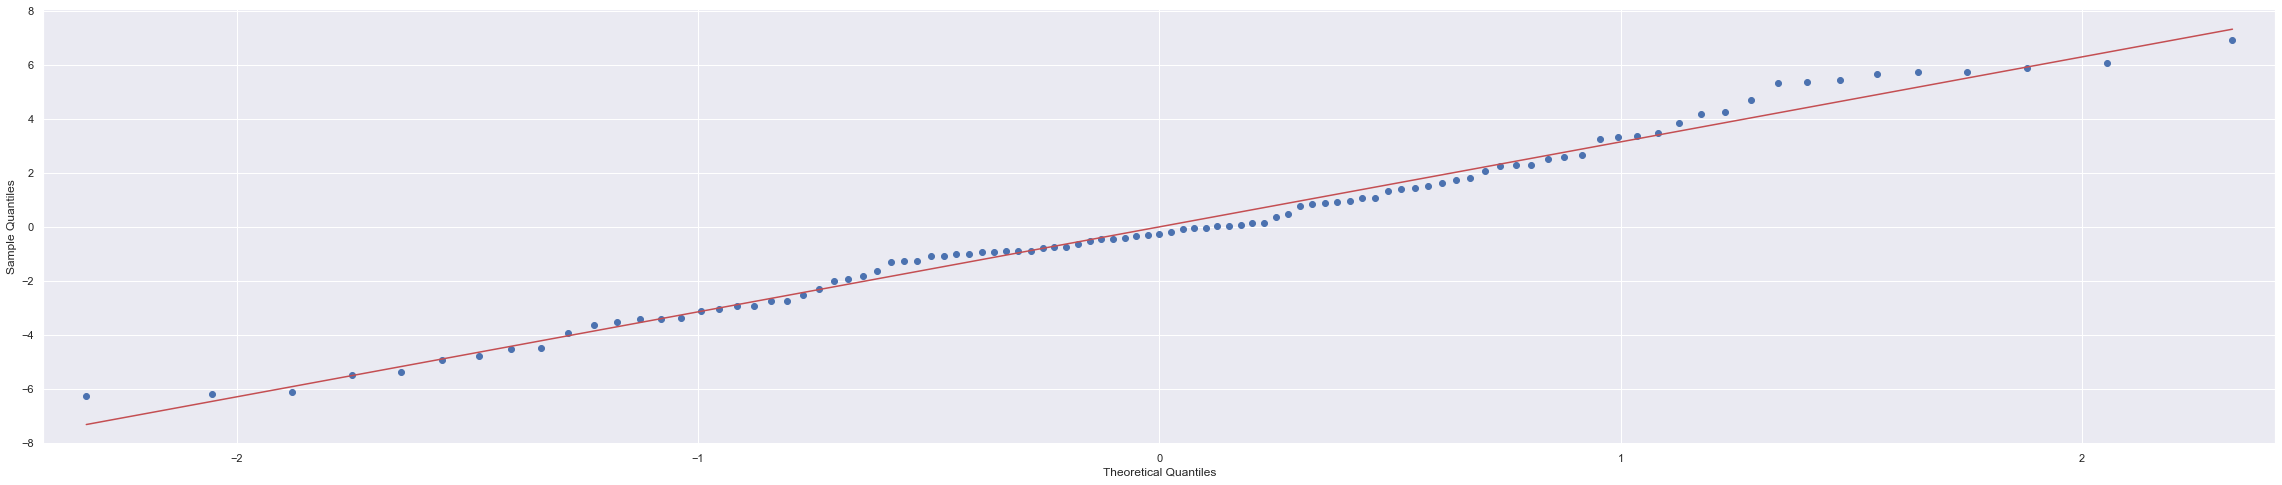

In [69]:
fig = sm.qqplot(residual, line = 'r')
plt.show()
fig.savefig("../data_visualization/Q-Q Plot for Car Fit.png")

In [70]:
residual

1    -5.373916
2     4.722580
3    -4.807147
4    -0.797073
5     1.399629
        ...   
95   -0.282507
96   -0.459159
97   -0.878575
98   -0.088114
99    3.361604
Length: 99, dtype: float64

In [71]:
sel_x_test = test_x[['Days on Market_1diff', 'US_UR_1diff', 'New Listings MoM_1diff', 'DMV_UR_log_1diff', 'Average Sale To List MoM_1diff', 'DMV_PER_1diff', 'WDXRSA_1diff']]
test_X = sm.add_constant(sel_x_test)
res.predict(test_X)

100         NaN
101   -0.833328
102   -1.991075
103   -3.481572
104    1.548816
105   -2.276361
106    0.920038
107    0.299704
108    5.451675
109    1.572813
110   -0.136699
111    0.815945
112    3.753112
113   -0.956970
114   -0.415322
115   -3.523594
116    2.494159
dtype: float64

In [ ]:
residual

In [ ]:
residual

In [ ]:
def MoM_trans(data = residual, ini_value = df['Median Sale Price'][0]):
    pred_y = []
    pred_y.append(ini_value)
    for i in range(len(data)):
        temp = pred_y[i]*(1 - data[i + 1 ]/100)
        pred_y.append(temp)
    return pred_y

In [ ]:
pred_y = MoM_trans()

In [ ]:
train_y = df["Median Sale Price MoM"][1:100]
test_y = df["Median Sale Price MoM"][101:117]

In [ ]:
error = df["Median Sale Price"][1:100] - pred_y[1:100]

In [ ]:
#MAE
np.mean(abs(error))

In [ ]:
#MAPE
np.mean(abs(error)/df["Median Sale Price"][1:100])

In [ ]:
residual

In [ ]:
temp = res.predict(test_X).reset_index()[0]
temp.index += 1

In [ ]:
pred_y_oot = MoM_trans(data = temp, ini_value = df['Median Sale Price'][99])

In [ ]:
len(pred_y_oot)

In [ ]:
error_oot = df["Median Sale Price"][100:117] - pred_y_oot[0:17]

In [ ]:
np.mean((abs(error_oot)))

In [ ]:
np.mean((abs(error_oot))/df["Median Sale Price"][100:117])

### Create a dataset for plot

In [ ]:
temp = pred_y + pred_y_oot
type(temp)
temp = pd.Series(temp)

In [ ]:
df_temp = pd.read_csv("../data/full_data.csv")
df_predict = pd.DataFrame(df_temp['Time'])
df_predict["Median Sale Price"] = df["Median Sale Price"]
df_predict['In Time'] = pd.Series(temp, index=df1.index)
df_predict['OOT Time'] = df_predict['In Time']
df_predict = df_predict[1:117]
df_predict.to_csv('../data/df_predict.csv')

In [3]:
df_predict = pd.read_csv('../data/df_predict.csv')

In [4]:
df_predict['In Time'][0:99]
df_predict['In Time'][99:116]

99     311000.000000
100    313591.649686
101    319835.494708
102    330970.796961
103    325844.668435
104    333262.068821
105    330195.932770
106    329206.320712
107    311259.063471
108    306363.541622
109    306782.336310
110    304279.162626
111    292859.226301
112    295661.800007
113    296889.748230
114    307350.936613
115    299685.115077
Name: In Time, dtype: float64

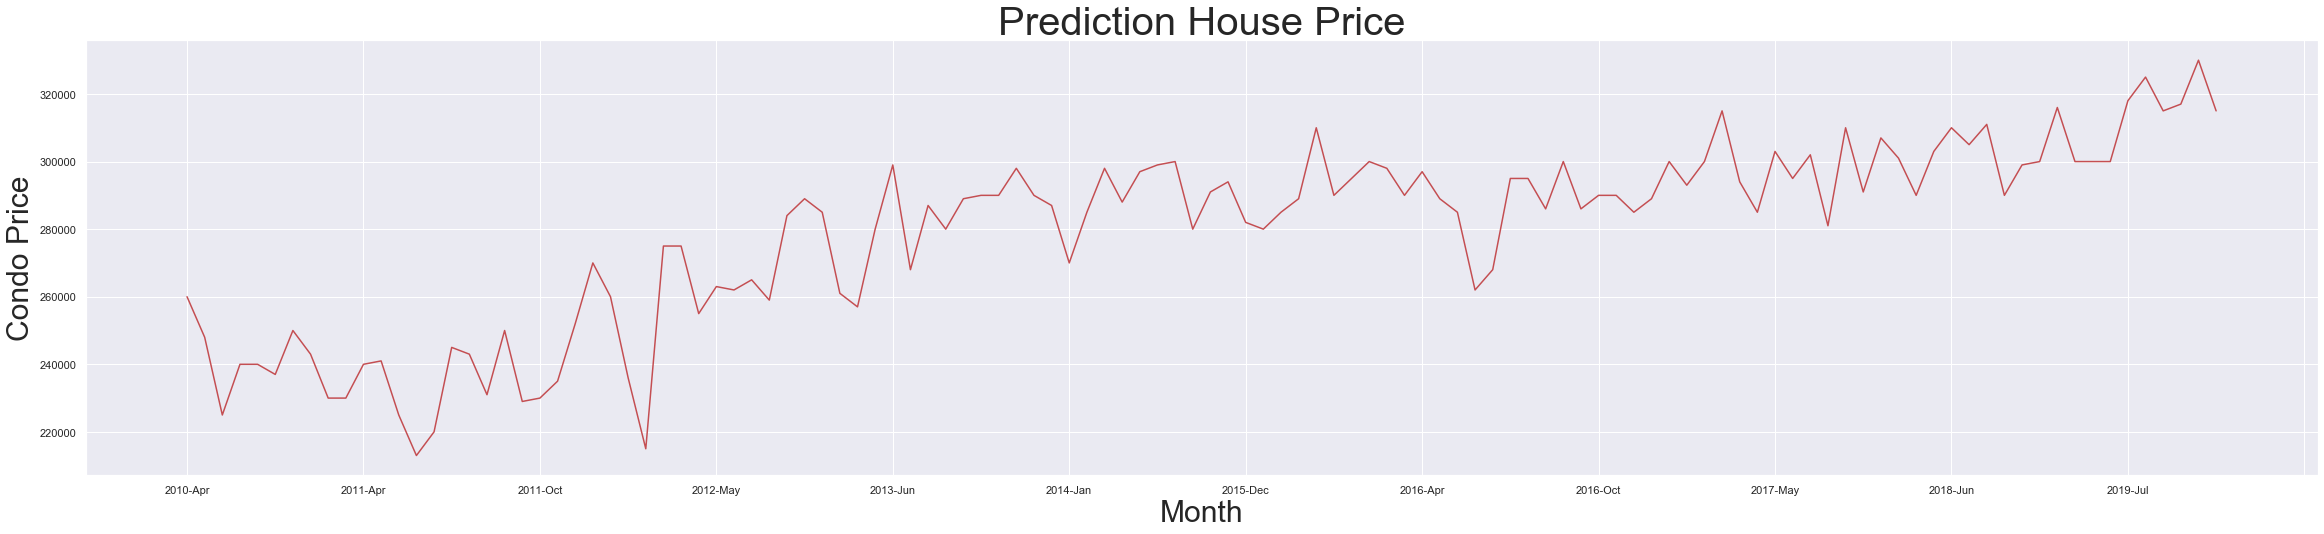

In [7]:
sns.lineplot(x = "Time", y = "Median Sale Price", color = 'r', err_style='bars',
            markers = ["x"], data = df_predict)
sns.set(rc={'figure.figsize':(40,8)})
plt.xticks(range(0, 130, 10))
plt.title("Prediction House Price", fontsize = 40)
plt.xlabel("Month", fontsize = 30)
plt.ylabel("Condo Price", fontsize = 30)
plt.show()

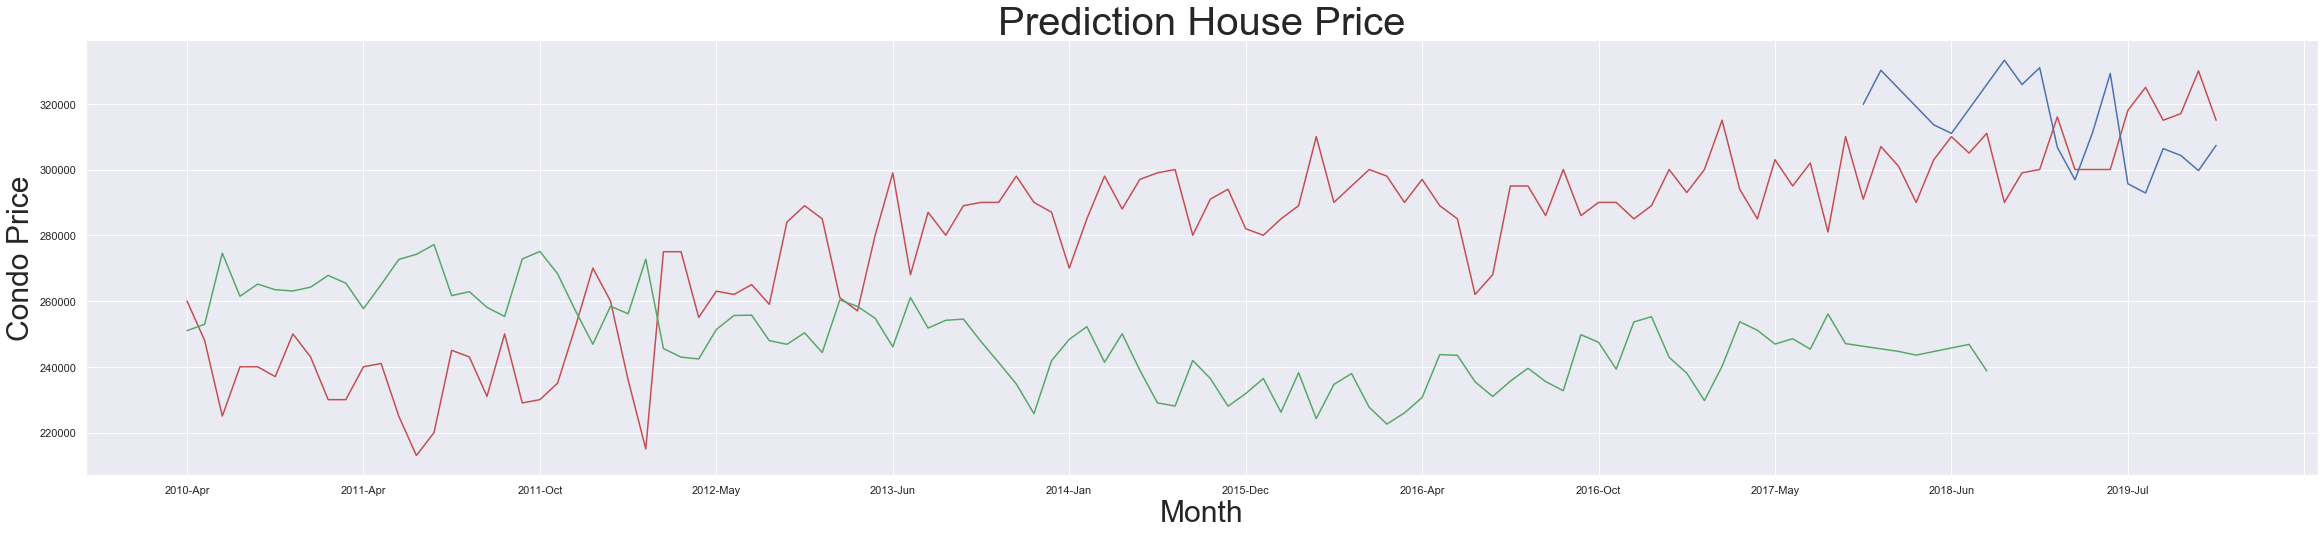

In [13]:
ax1 = sns.lineplot(x = "Time", y = "Median Sale Price", color = 'r', err_style='bars',
            markers = ["o"], data = df_predict)
ax2 = sns.lineplot(x = "Time", y = "In Time", color = 'g', dashes = "+", data = df_predict[0:99])
ax3 = sns.lineplot(x = "Time", y = "OOT Time", color = 'b', dashes = True, data = df_predict[99:116])
sns.set(rc={'figure.figsize':(40,8)})
plt.xticks(range(0, 130, 10))
plt.title("Prediction House Price", fontsize = 40)
plt.xlabel("Month", fontsize = 30)
plt.ylabel("Condo Price", fontsize = 30)
plt.show()

In [ ]:
def MAE(pred_y, act_y):
    return np.mean(abs(res.predict(test_X) - test_y))

In [ ]:
def MAPE(pred_y, act_y):
    size = len(pred_y)
    ape = []
    for i in range(size):
        ape.append()

In [ ]:
res.model.exog
het_breuschpagan(residual, res.model.exog)

In [ ]:
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = het_breuschpagan(residual, res.model.exog)
lzip(name, test)

In [ ]:
name = ['F statistic', 'p-value']
test = het_goldfeldquandt(residual, res.model.exog)
lzip(name, test)